第一个因子假设：如下使用的是修正动量指标SRMI，数据为周期为4H的BTCUSDT:binance。首先使用周期为4H的BTCUSDT:binance数据计算因子，画出价格图与因子图，发现因子与价格大致呈现同涨同跌的关系，且时间相差不大，由于因子的波动幅度太大，于是采用计算移动平均线的方法平滑因子值。再用周期为4H的BTCUSDT:binance数据画出价格图与成交量的图，发现价格出现反转的地方，成交量也会随之增加。根据以上观察到的两个信息，设定10日均线上穿30日均线并且成交量增加为买入信号，10日均线下穿30日均线并且成交量增加为卖出信号。

In [1]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
from time import time
ds = LocalDataService()
## 加freq参数
start = time()
path = r'.\min_data\VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1Min,5Min,15Min,30Min,1H,4H,6H,8H,12H',
         'start_date':20180601000000}

btc = ds.bar_reader(path,props) #读取数据
print(time()-start)

5.6723244190216064


In [91]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [88]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1 = HFDataView()
dv1.create_init_dv(btc['4H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [62]:
SRMI1 = dv1.add_formula('SRMI_J', "(close-Delay(close,10))/Max(close,Delay(close,10))" ,add_data=True)

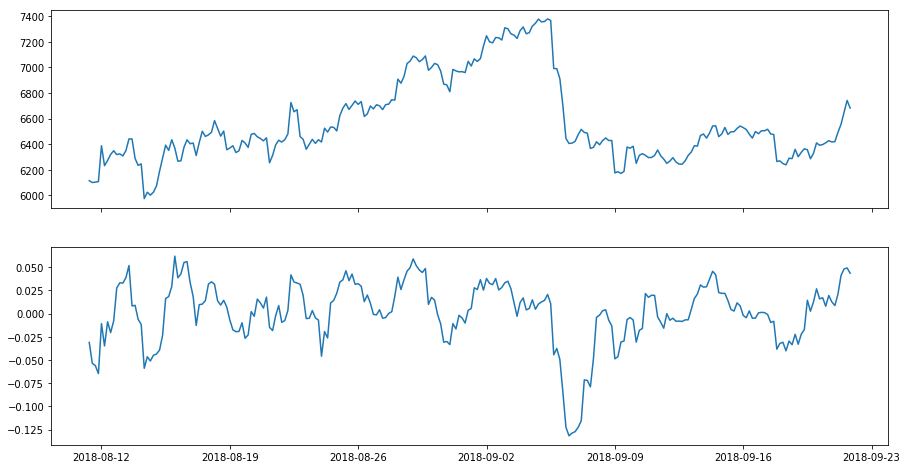

In [9]:
alpha1_plot = dv1.get_ts('SRMI_J', date_type='datetime')
close = dv1.get_ts('close', date_type='datetime')
plot_chart(close, alpha1_plot)

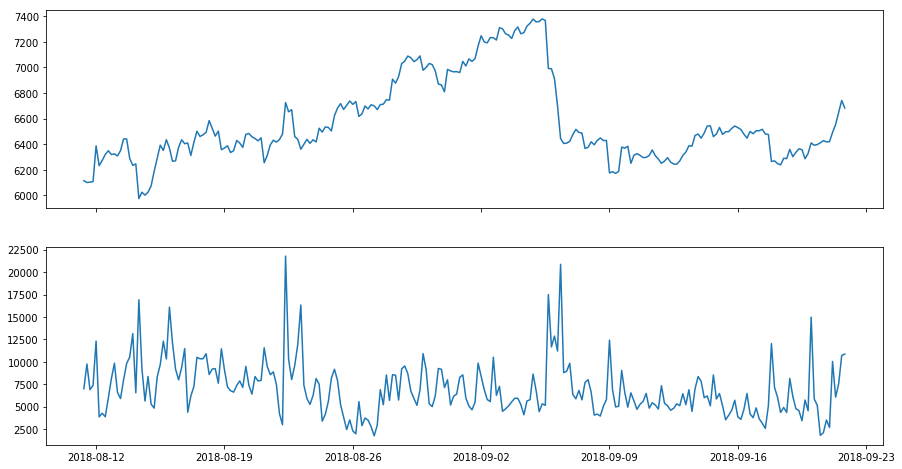

In [11]:
alpha1_plot = dv1.get_ts('volume', date_type='datetime')
close = dv1.get_ts('close', date_type='datetime')
plot_chart(close, alpha1_plot)

In [78]:
# 进场信号
long = dv1.add_formula("longSRMI","If((Ts_Mean(SRMI_J,10)>Ts_Mean(SRMI_J,30)) && (Delay(Ts_Mean(SRMI_J,10),1)<=Delay(Ts_Mean(SRMI_J,30),1)) && Return(volume,1)>0,2,0)", add_data=True)
short = dv1.add_formula("shortSRMI","If((Ts_Mean(SRMI_J,10)<Ts_Mean(SRMI_J,30)) && (Delay(Ts_Mean(SRMI_J,10),1)>=Delay(Ts_Mean(SRMI_J,30),1)) && Return(volume,1)>0,-2,0)", add_data=True)

# 出场信号
close_long = dv1.add_formula("closeLongSRMI","If(shortSRMI==-2,1,0)", add_data=True)
close_short = dv1.add_formula("closeShortSRMI","If(longSRMI==2,-1,0)", add_data=True)

Field [longSRMI] is overwritten.
Field [shortSRMI] is overwritten.
Field [closeLongSRMI] is overwritten.
Field [closeShortSRMI] is overwritten.


In [13]:
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [79]:
from jaqs_fxdayu.research import TimingDigger

tdSRMI = TimingDigger(output_folder=".", output_format='pdf',signal_name='SRMI')
TimingSignal(tdSRMI, dv1,'longSRMI','shortSRMI','closeLongSRMI','closeShortSRMI', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%


In [80]:
tdSRMI.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              2.549 -5.306   0.573
p-value             0.034  0.001   0.575
mean                0.052 -0.039   0.009
std                 0.057  0.019   0.063
info_ratio          0.901 -2.005   0.143
skewness            1.998 -0.041   1.543
kurtosis            2.820 -1.616   2.923
pct5                0.006 -0.063  -0.058
pct25               0.022 -0.056  -0.027
pct50               0.041 -0.039   0.001
pct75               0.050 -0.021   0.041
pct95               0.149 -0.015   0.093
occurance           9.000  8.000  17.000
win_ratio             NaN    NaN   0.529
win_mean/loss_mean    NaN    NaN   1.326


In [81]:
tdSRMI.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win   loss     all
t-stat               2.694 -6.993   0.704
p-value              0.025  0.000   0.491
mean                 0.050 -0.039   0.011
std                  0.056  0.015   0.062
info_ratio           0.898 -2.643   0.171
skewness             1.160  0.781   1.222
kurtosis            -0.305 -0.278   0.753
pct5                 0.006 -0.056  -0.054
pct25                0.009 -0.052  -0.038
pct50                0.027 -0.040   0.006
pct75                0.062 -0.034   0.029
pct95                0.156 -0.015   0.153
occurance           10.000  8.000  18.000
win_ratio              NaN    NaN   0.556
win_mean/loss_mean     NaN    NaN   1.285


In [82]:
tdSRMI.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.816  -8.755   0.916
p-value              0.001   0.000   0.366
mean                 0.051  -0.039   0.010
std                  0.057   0.017   0.062
info_ratio           0.899  -2.261   0.157
skewness             1.572   0.220   1.382
kurtosis             1.275  -1.163   1.841
pct5                 0.005  -0.059  -0.056
pct25                0.012  -0.054  -0.037
pct50                0.031  -0.040   0.006
pct75                0.057  -0.025   0.033
pct95                0.164  -0.011   0.154
occurance           19.000  16.000  35.000
win_ratio              NaN     NaN   0.543
win_mean/loss_mean     NaN     NaN   1.304


第二个因子假设：用上述类似方法，计算出ROC6因子的值，并画出价格和因子值的图，同样发现因子值与价格大致同涨同跌，且因子值的变化幅度也较大，需要做移动平均线处理，结合之前观察到的成交量与价格关系的信息，做出当ROC6因子值的10日均线上穿20日均线，并且成交量增加时，为买入信号，当ROC6因子值的10日均线下穿20日均线并且成交量增加时，为卖出信号的假设。

In [90]:
ROC61 = dv1.add_formula('ROC6', '((close/Delay(close, 6))-1)*100', add_data=True)

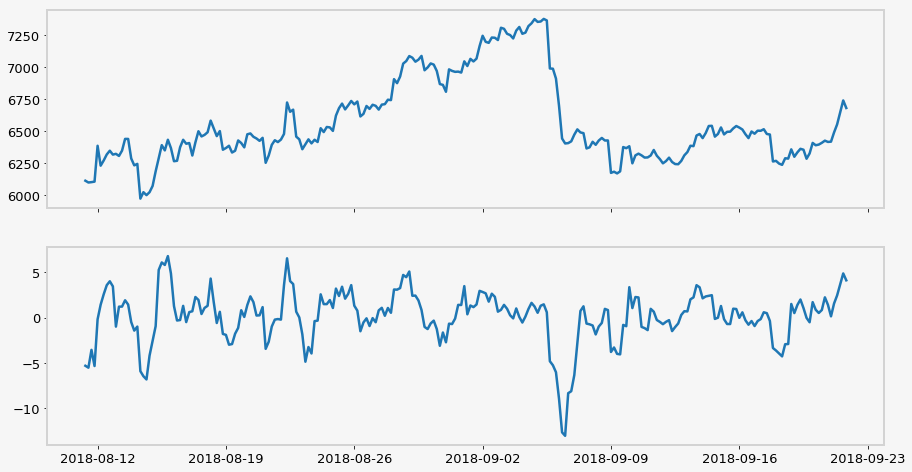

In [93]:
alpha1_plot = dv1.get_ts('ROC6', date_type='datetime')
close = dv1.get_ts('close', date_type='datetime')
plot_chart(close, alpha1_plot)

使用周期为4H的BTCUSDT:binance数据：

In [26]:
# 进场信号
long = dv1.add_formula("longROC6","If((Ts_Mean(ROC6,10)>Ts_Mean(ROC6,20)) && (Delay(Ts_Mean(ROC6,10),1)<=Delay(Ts_Mean(ROC6,20),1)) && Return(volume,1)>0,2,0)", add_data=True)
short = dv1.add_formula("shortROC6","If((Ts_Mean(ROC6,10)<Ts_Mean(ROC6,20)) && (Delay(Ts_Mean(ROC6,10),1)>=Delay(Ts_Mean(ROC6,20),1)) && Return(volume,1)>0,-2,0)", add_data=True)

# 出场信号
close_long = dv1.add_formula("closeLongROC6","If(shortROC6==-2,1,0)", add_data=True)
close_short = dv1.add_formula("closeShortROC6","If(longROC6==2,-1,0)", add_data=True)

In [27]:
tdROC6 = TimingDigger(output_folder=".", output_format='pdf',signal_name='ROC6')
TimingSignal(tdROC6, dv1,'longROC6','shortROC6','closeLongROC6','closeShortROC6', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%


In [28]:
tdROC6.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              2.685  -3.648   0.662
p-value             0.036   0.002   0.515
mean                0.070  -0.019   0.008
std                 0.064   0.020   0.057
info_ratio          1.096  -0.942   0.141
skewness            1.266  -1.618   1.963
kurtosis            0.256   1.183   4.535
pct5                0.015  -0.059  -0.053
pct25               0.033  -0.017  -0.013
pct50               0.042  -0.010  -0.009
pct75               0.083  -0.009   0.020
pct95               0.179  -0.003   0.108
occurance           7.000  16.000  23.000
win_ratio             NaN     NaN   0.304
win_mean/loss_mean    NaN     NaN   3.658


In [29]:
tdROC6.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.654  -5.594   1.070
p-value              0.003   0.000   0.296
mean                 0.047  -0.033   0.012
std                  0.044   0.018   0.053
info_ratio           1.055  -1.865   0.228
skewness             0.801  -0.211   0.805
kurtosis            -0.666  -0.881  -0.083
pct5                 0.005  -0.059  -0.050
pct25                0.007  -0.045  -0.026
pct50                0.029  -0.033   0.006
pct75                0.073  -0.020   0.031
pct95                0.126  -0.009   0.114
occurance           13.000  10.000  23.000
win_ratio              NaN     NaN   0.565
win_mean/loss_mean     NaN     NaN   1.418


In [30]:
tdROC6.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.500  -5.970   1.227
p-value              0.000   0.000   0.226
mean                 0.055  -0.024   0.010
std                  0.053   0.020   0.055
info_ratio           1.032  -1.194   0.183
skewness             1.298  -0.927   1.434
kurtosis             1.104  -0.421   2.445
pct5                 0.006  -0.063  -0.053
pct25                0.008  -0.040  -0.018
pct50                0.033  -0.015  -0.005
pct75                0.076  -0.009   0.031
pct95                0.143  -0.004   0.116
occurance           20.000  26.000  46.000
win_ratio              NaN     NaN   0.435
win_mean/loss_mean     NaN     NaN   2.244


In [87]:
tdROC6_2.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.660  -9.888   1.359
p-value              0.000   0.000   0.181
mean                 0.096  -0.049   0.020
std                  0.094   0.024   0.099
info_ratio           1.017  -2.062   0.203
skewness             1.091   0.658   1.418
kurtosis             0.145  -0.719   1.500
pct5                 0.005  -0.072  -0.069
pct25                0.015  -0.063  -0.060
pct50                0.074  -0.060  -0.004
pct75                0.115  -0.026   0.061
pct95                0.303  -0.006   0.237
occurance           22.000  24.000  46.000
win_ratio              NaN     NaN   0.478
win_mean/loss_mean     NaN     NaN   1.940
